## Transak EDA with seaborn 

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import seaborn as sns


In [2]:
client = bigquery.Client(project="af-finanzen")
# query = ("""
#     SELECT
#       description
#       -- , Konto
#       , CASE 
#           WHEN Konto in ("PK Auto", "PK Maja", "PK Rest", "SK Haushalt", "Top-Up") THEN "Others"
#           ELSE Konto
#         END as Konto
#     FROM banks.revolut_mapping_internal
# """)
query = ("""
    SELECT
         R.*
         , CASE 
           WHEN Konto in ("PK Auto", "PK Maja", "PK Rest", "SK Haushalt", "Top-Up") THEN "Others"
           ELSE Konto
         END as konto
    FROM banks.revolut_v R
    LEFT JOIN banks.revolut_mapping_internal RMI
         ON R.description = RMI.description
""")
df = client.query(query).to_dataframe()  # API request


In [3]:
df.head()

type  product             started           completed  \
0  CARD_PAYMENT  Current 2022-09-05 21:02:24 2022-09-06 18:54:29   
1  CARD_PAYMENT  Current 2024-02-13 23:11:03 2024-02-15 03:40:42   
2  CARD_PAYMENT  Current 2022-04-25 15:03:16 2022-04-26 12:44:59   
3  CARD_PAYMENT  Current 2022-04-25 15:14:49 2022-04-26 12:45:03   
4  CARD_PAYMENT  Current 2023-08-18 12:07:20 2023-08-19 15:34:03   

                 description         amount   fee currency      state  \
0  18 Brzeczkowice Manual (1   -2.690000000  0E-9      CHF  COMPLETED   
1                    ASFINAG  -10.950000000  0E-9      CHF  COMPLETED   
2           Apteka Słoneczna  -21.990000000  0E-9      CHF  COMPLETED   
3           Apteka Słoneczna   -6.400000000  0E-9      CHF  COMPLETED   
4           Apteka Słoneczna  -16.910000000  0E-9      CHF  COMPLETED   

         balance account    month       first_started      konto  
0  390.450000000     CHF  2022-09 2022-09-05 21:02:24  PK Reisen  
1   43.610000000     CHF  2024-02 2024-02-13 23:11:03  PK Reisen  
2  108.700000000     CHF  2022-04 2022-04-25 15:03:16   PK Leben  
3  102.300000000     CHF  2022-04 2022-04-25 15:03:16   PK Leben  
4  280.510000000     CHF  2023-08 2022-04-25 15:03:16   PK Leben

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883 entries, 0 to 1882
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   type           1883 non-null   object        
 1   product        1883 non-null   object        
 2   started        1883 non-null   datetime64[ns]
 3   completed      1880 non-null   datetime64[ns]
 4   description    1883 non-null   object        
 5   amount         1883 non-null   object        
 6   fee            1883 non-null   object        
 7   currency       1883 non-null   object        
 8   state          1883 non-null   object        
 9   balance        1880 non-null   object        
 10  account        1883 non-null   object        
 11  month          1883 non-null   object        
 12  first_started  1883 non-null   datetime64[ns]
 13  konto          1883 non-null   object        
dtypes: datetime64[ns](3), object(11)
memory usage: 206.1+ KB


convert types

In [5]:
df.nunique()

type                7
product             1
started          1875
completed        1736
description       402
amount           1222
fee               166
currency            3
state               2
balance          1832
account             3
month              38
first_started     402
konto               5
dtype: int64

In [6]:
df.konto.value_counts()

konto
Others       842
PK Leben     488
PK Reisen    258
PK Artur     178
SK Ferien    117
Name: count, dtype: int64

In [7]:
df.groupby('konto').konto.count()

konto
Others       842
PK Artur     178
PK Leben     488
PK Reisen    258
SK Ferien    117
Name: konto, dtype: int64

In [8]:
konto_mapping = {'Others': 1, 'PK Artur': 2, 'PK Leben': 3, 'PK Reisen': 4, 'SK Ferien':5 }

In [9]:
df['konto'] = df.konto.apply(lambda x: konto_mapping[x])

In [10]:
# One Hot encoding

In [11]:
df = pd.get_dummies(df, columns=['type', 'currency', 'state', 'account'])

In [12]:
df.amount = df.amount.astype(float)
df.fee = df.fee.astype(float)
df.balance = df.balance.astype(float)

# Cyclic transformations

df.started

In [13]:
df['started_day'] = df.started.dt.day
df['started_day_sin'] = np.sin((df.started_day-1)*(2.*np.pi/31))
df['started_day_cos'] = np.cos((df.started_day-1)*(2.*np.pi/31))
df['started_month'] = df.started.dt.month
df['started_month_sin'] = np.sin((df.started_month-1)*(2.*np.pi/12))
df['started_month_cos'] = np.cos((df.started_month-1)*(2.*np.pi/12))
df['started_year'] = df.started.dt.year
df.drop(columns=['started'], inplace=True)


df.completed

In [14]:
df['completed_day'] = df.completed.dt.day
df['completed_day_sin'] = np.sin((df.completed_day-1)*(2.*np.pi/31))
df['completed_day_cos'] = np.cos((df.completed_day-1)*(2.*np.pi/31))
df['completed_month'] = df.completed.dt.month
df['completed_month_sin'] = np.sin((df.completed_month-1)*(2.*np.pi/12))
df['completed_month_cos'] = np.cos((df.completed_month-1)*(2.*np.pi/12))
df['completed_year'] = df.completed.dt.year
df.drop(columns=['completed'], inplace=True)


df.first_started

In [15]:
df['first_started_day'] = df.first_started.dt.day
df['first_started_day_sin'] = np.sin((df.first_started_day-1)*(2.*np.pi/31))
df['first_started_day_cos'] = np.cos((df.first_started_day-1)*(2.*np.pi/31))
df['first_started_month'] = df.first_started.dt.month
df['first_started_month_sin'] = np.sin((df.first_started_month-1)*(2.*np.pi/12))
df['first_started_month_cos'] = np.cos((df.first_started_month-1)*(2.*np.pi/12))
df['first_started_year'] = df.first_started.dt.year
df.drop(columns=['first_started'], inplace=True)


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883 entries, 0 to 1882
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product                  1883 non-null   object 
 1   description              1883 non-null   object 
 2   amount                   1883 non-null   float64
 3   fee                      1883 non-null   float64
 4   balance                  1880 non-null   float64
 5   month                    1883 non-null   object 
 6   konto                    1883 non-null   int64  
 7   type_ATM                 1883 non-null   bool   
 8   type_CARD_PAYMENT        1883 non-null   bool   
 9   type_CARD_REFUND         1883 non-null   bool   
 10  type_EXCHANGE            1883 non-null   bool   
 11  type_FEE                 1883 non-null   bool   
 12  type_TOPUP               1883 non-null   bool   
 13  type_TRANSFER            1883 non-null   bool   
 14  currency_CHF            

In [17]:
df.columns

Index(['product', 'description', 'amount', 'fee', 'balance', 'month', 'konto',
       'type_ATM', 'type_CARD_PAYMENT', 'type_CARD_REFUND', 'type_EXCHANGE',
       'type_FEE', 'type_TOPUP', 'type_TRANSFER', 'currency_CHF',
       'currency_EUR', 'currency_PLN', 'state_COMPLETED', 'state_REVERTED',
       'account_CHF', 'account_EUR', 'account_PLN', 'started_day',
       'started_day_sin', 'started_day_cos', 'started_month',
       'started_month_sin', 'started_month_cos', 'started_year',
       'completed_day', 'completed_day_sin', 'completed_day_cos',
       'completed_month', 'completed_month_sin', 'completed_month_cos',
       'completed_year', 'first_started_day', 'first_started_day_sin',
       'first_started_day_cos', 'first_started_month',
       'first_started_month_sin', 'first_started_month_cos',
       'first_started_year'],
      dtype='object')

In [18]:
df.describe()

amount          fee      balance        konto  started_day  \
count  1883.000000  1883.000000  1880.000000  1883.000000  1883.000000   
mean      0.228455     0.205608   202.484404     2.272438    16.153478   
std     221.363135     0.810870   238.208843     1.319203     9.008340   
min   -2984.580000    -0.470000   -46.460000     1.000000     1.000000   
25%     -38.335000     0.000000    67.672500     1.000000     8.000000   
50%      -4.980000     0.000000   149.395000     2.000000    16.000000   
75%      40.000000     0.060000   249.410000     3.000000    24.000000   
max    3000.000000    16.910000  3150.480000     5.000000    31.000000   

       started_day_sin  started_day_cos  started_month  started_month_sin  \
count      1883.000000      1883.000000    1883.000000        1883.000000   
mean         -0.025922        -0.004382       6.970791          -0.066875   
std           0.679522         0.733546       3.323618           0.690311   
min          -0.998717        -0.994869       1.000000          -1.000000   
25%          -0.651372        -0.758758       4.000000          -0.866025   
50%           0.000000        -0.050649       7.000000           0.000000   
75%           0.651372         0.688967      10.000000           0.500000   
max           0.998717         1.000000      12.000000           1.000000   

       started_month_cos  ...  completed_month_sin  completed_month_cos  \
count       1.883000e+03  ...          1880.000000         1.880000e+03   
mean       -7.157461e-02  ...            -0.069280        -7.573547e-02   
std         7.172179e-01  ...             0.690052         7.168119e-01   
min        -1.000000e+00  ...            -1.000000        -1.000000e+00   
25%        -8.660254e-01  ...            -0.866025        -8.660254e-01   
50%        -1.836970e-16  ...             0.000000        -1.836970e-16   
75%         5.000000e-01  ...             0.500000         5.000000e-01   
max         1.000000e+00  ...             1.000000         1.000000e+00   

       completed_year  first_started_day  first_started_day_sin  \
count     1880.000000        1883.000000            1883.000000   
mean      2022.202128          20.281997              -0.152785   
std          0.825741           9.836475               0.626789   
min       2021.000000           1.000000              -0.998717   
25%       2022.000000          12.000000              -0.571268   
50%       2022.000000          23.000000              -0.394356   
75%       2023.000000          30.000000               0.394356   
max       2024.000000          31.000000               0.998717   

       first_started_day_cos  first_started_month  first_started_month_sin  \
count            1883.000000          1883.000000              1883.000000   
mean                0.305692             4.858205                 0.027173   
std                 0.700581             3.488796                 0.529100   
min                -0.994869             1.000000                -1.000000   
25%                -0.345523             1.000000                -0.500000   
50%                 0.528964             5.000000                 0.000000   
75%                 0.918958             8.000000                 0.500000   
max                 1.000000            12.000000                 1.000000   

       first_started_month_cos  first_started_year  
count              1883.000000         1883.000000  
mean                  0.122625         2021.428571  
std                   0.839524            0.732262  
min                  -1.000000         2021.000000  
25%                  -0.866025         2021.000000  
50%                   0.500000         2021.000000  
75%                   1.000000         2022.000000  
max                   1.000000         2024.000000  

[8 rows x 25 columns]

In [19]:
sns.pairplot(df)

c:\Users\admin\.conda\envs\af-finanzen\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\admin\.conda\envs\af-finanzen\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\admin\.conda\envs\af-finanzen\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\admin\.conda\envs\af-finanzen\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

histograms

array([[<Axes: title={'center': 'started_month'}>,
        <Axes: title={'center': 'completed_month'}>],
       [<Axes: title={'center': 'first_started_month'}>, <Axes: >]],
      dtype=object)

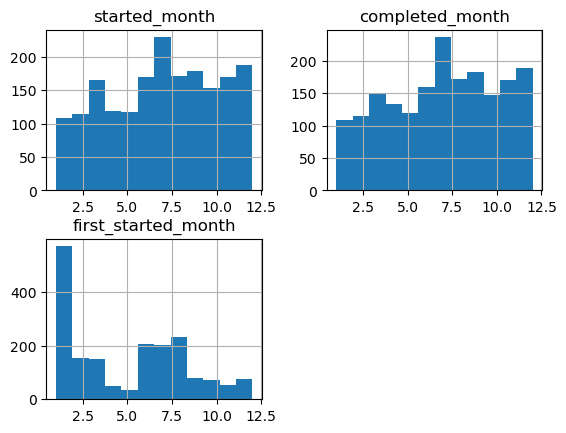

In [20]:
df.hist(column=['started_month', 'completed_month', 'first_started_month'], bins=12)

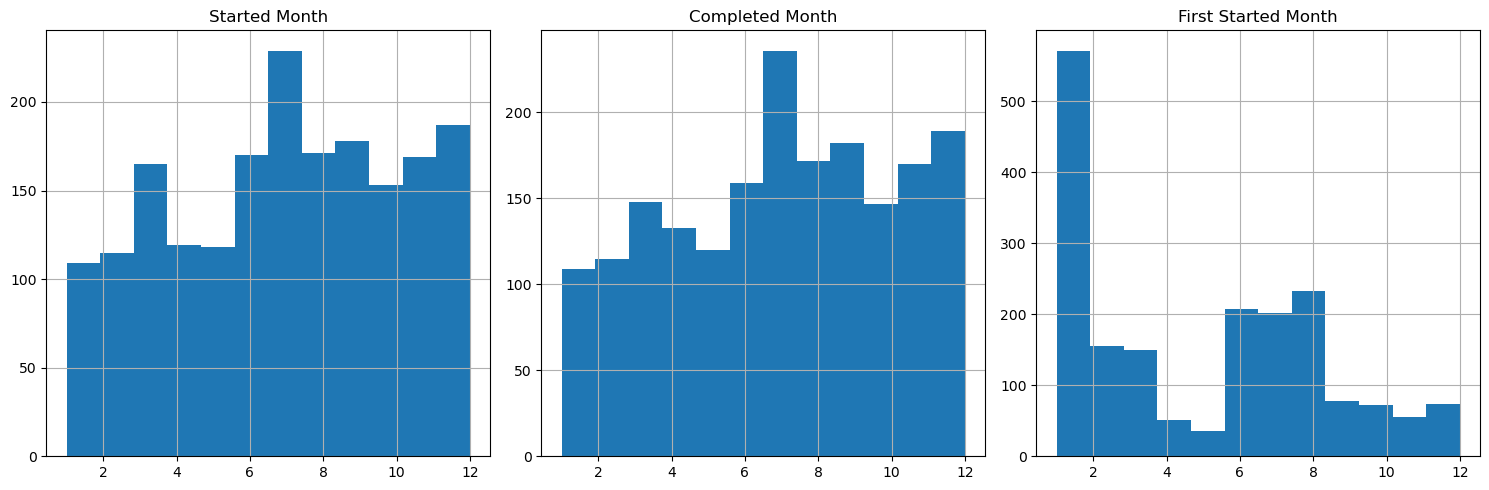

In [22]:
import matplotlib.pyplot as plt
#import pandas as pd

# Assuming 'df' is your pandas DataFrame
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create histograms for each column
df['started_month'].hist(bins=12, ax=axes[0])
df['completed_month'].hist(bins=12, ax=axes[1])
df['first_started_month'].hist(bins=12, ax=axes[2])

# Set titles for each subplot
axes[0].set_title('Started Month')
axes[1].set_title('Completed Month')
axes[2].set_title('First Started Month')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


<Axes: >

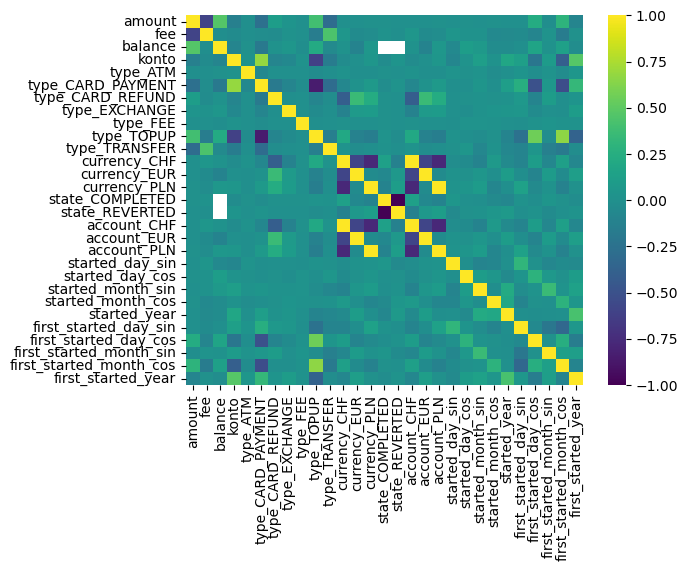

In [35]:
df_corr = df.drop(columns=['product', 'description', 'month', 'started_day', 'started_month', 'completed_day', 'completed_day_sin', 'completed_day_cos', 'completed_month', 'completed_month_sin', 'completed_month_cos', 'completed_year', 'first_started_day', 'first_started_month' ]
                  , axis=1)
#sns.heatmap(df_corr.corr(), annot=True, fmt="d", cmap="viridis")
sns.heatmap(df_corr.corr(), annot=False, cmap="viridis", xticklabels=True, yticklabels=True)
#sns.heatmap(df_corr.corr())


In [32]:
df_corr.columns

Index(['amount', 'fee', 'balance', 'konto', 'type_ATM', 'type_CARD_PAYMENT',
       'type_CARD_REFUND', 'type_EXCHANGE', 'type_FEE', 'type_TOPUP',
       'type_TRANSFER', 'currency_CHF', 'currency_EUR', 'currency_PLN',
       'state_COMPLETED', 'state_REVERTED', 'account_CHF', 'account_EUR',
       'account_PLN', 'started_day', 'started_day_sin', 'started_day_cos',
       'started_month', 'started_month_sin', 'started_month_cos',
       'started_year', 'completed_day', 'completed_day_sin',
       'completed_day_cos', 'completed_month', 'completed_month_sin',
       'completed_month_cos', 'completed_year', 'first_started_day',
       'first_started_day_sin', 'first_started_day_cos', 'first_started_month',
       'first_started_month_sin', 'first_started_month_cos',
       'first_started_year'],
      dtype='object')